In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd 'drive/My Drive/Siamese/Identification'

/content/drive/My Drive/Siamese/Identification


In [3]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../Data')
sys.path.insert(0, '../Encoder')

In [4]:
!pip install torchaudio

     |████████████████████████████████| 6.7MB 2.5MB/s 


In [5]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [6]:
DATASET_PATH = '/content/drive/My Drive/DataSet'
MODEL_PATH = '/content/drive/My Drive/Siamese/net.nn'
EPOCH_NUM = 6
SPEAKERS_NUM = 20

torch.backends.cudnn.deterministic = True

NUM_WORKERS = 4

In [7]:
from IdentificationDataset import IdentificationDataset
from IdentificationDataset import ReturnType

from torchvision.transforms import Compose
from Normalize import Normalize
from ToTensor import ToTensor

DATASET_PATH = '/content/drive/My Drive/DataSet'

transforms = Compose([
    Normalize(),
    ToTensor()
])

testset = IdentificationDataset(DATASET_PATH, 
                                SPEAKERS_NUM,
                                train=False, 
                                transform=transforms,
                                lenght=3,
                                return_type=ReturnType.STANDARD)
testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=1, 
                                            num_workers=NUM_WORKERS)

print("lenght test loader ", len(testsetloader))


sample lenght  3
lenght test loader  2134


In [8]:
from Conference import Conference

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
net = Conference(DEVICE,
              time=False)

net.load_encoder(size=3)
net.to(DEVICE)

cuda
Encoder loaded


Conference(
  (encoder): TransFourier(
    (spectrogram): Spectrogram()
    (amp): AmplitudeToDB()
    (block1): Conv2DBlock(
      (conv1): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 1), padding=(3, 3))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Conv2DBlock(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Conv2d(128, 192, kernel_size=(5, 5), stride=(2, 1), padding=(2, 2))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Conv2DBlock(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Co

In [9]:
with torch.no_grad():
  # test
  net.eval()
  # Store the speakers
  speakers_list = testset.get_speakers_list(20)
  net.initspeakers(speakers_list)  
  net.initplaces(speakers_list)

In [10]:
import numpy as np

dict_error = {}
dict_nb = {}

conf_gold_label = None
conf_pred_label = None

with torch.no_grad():
  best_accuracy = 0
  mean_accuracies = []
  topk_accuracies = []
  min_accuracies = []

  for epoch_num in range(EPOCH_NUM):
    print("*** Epoch ", epoch_num, " ***")
    mean_accuracy = 0
    topk_accuracy = 0
    min_accuracy = 0
    nb_test = 0
    if epoch_num == EPOCH_NUM-1:
      print("activate stats")
      net.activatestats()
      # Confusion matrix
      conf_gold_label = []
      conf_pred_label = []

    for speaker in speakers_list:
      id = speaker[0]
      dict_error[id] = 0
      dict_nb[id] = 0

    for iter_num, (gold_label, sample) in tqdm(enumerate(testsetloader)):
      mean_label, topk_label, min_label = net(sample, gold_label)
      if conf_gold_label != None:
        conf_gold_label.append(gold_label)
      if conf_pred_label != None:
        conf_pred_label.append(min_label)      

      nb_test += 1
      gold_label = gold_label.item()
      dict_nb[gold_label] += 1

      if gold_label == mean_label:
        mean_accuracy += 1
      if gold_label == topk_label:
        topk_accuracy += 1
      else:
        dict_error[gold_label] += 1
      if gold_label == min_label:
        min_accuracy += 1

    mean_accuracy /= nb_test
    topk_accuracy /= nb_test
    min_accuracy /= nb_test
    mean_accuracies.append(mean_accuracy)
    topk_accuracies.append(topk_accuracy)
    min_accuracies.append(min_accuracy)
    print("accuracy mean ", mean_accuracy, "topk", topk_accuracy, 
          " min ", min_accuracy)
    add = 0
    nb = 0
    for id in dict_error:
      add += dict_error[id]
      nb += dict_nb[id]
      dict_error[id] =  100 * dict_error[id]//dict_nb[id] 
    print("Error ", add/nb)
    print(dict_error)

  net.store_speakers(20, 3)
  means = net.dumpstats()

*** Epoch  0  ***


2134it [05:03,  7.03it/s]

accuracy mean  0.3514526710402999 topk 0.7436738519212746  min  0.7497656982193065
Error  0.2563261480787254
{270: 1, 272: 58, 273: 12, 274: 22, 275: 21, 276: 16, 277: 37, 278: 5, 271: 27, 279: 38, 280: 74, 281: 47, 282: 26, 283: 39, 285: 45, 284: 35, 286: 4, 287: 100, 288: 14, 289: 6}
*** Epoch  1  ***



2134it [00:55, 38.31it/s]

accuracy mean  0.5932521087160263 topk 0.8041237113402062  min  0.7900656044985942
Error  0.1958762886597938
{270: 8, 272: 62, 273: 20, 274: 12, 275: 18, 276: 18, 277: 17, 278: 5, 271: 23, 279: 20, 280: 34, 281: 32, 282: 23, 283: 26, 285: 27, 284: 4, 286: 4, 287: 81, 288: 12, 289: 6}
*** Epoch  2  ***



2134it [00:56, 37.99it/s]

accuracy mean  0.7146204311152765 topk 0.8074039362699157  min  0.7924086223055296
Error  0.19259606373008434
{270: 9, 272: 60, 273: 23, 274: 9, 275: 20, 276: 15, 277: 14, 278: 9, 271: 21, 279: 14, 280: 25, 281: 26, 282: 22, 283: 30, 285: 30, 284: 3, 286: 8, 287: 52, 288: 12, 289: 5}
*** Epoch  3  ***



2134it [00:56, 38.00it/s]

accuracy mean  0.7361761949390815 topk 0.8045923149015932  min  0.7994376757263355
Error  0.19540768509840675
{270: 10, 272: 42, 273: 27, 274: 11, 275: 22, 276: 17, 277: 16, 278: 8, 271: 23, 279: 17, 280: 14, 281: 26, 282: 23, 283: 31, 285: 34, 284: 4, 286: 8, 287: 29, 288: 14, 289: 6}
*** Epoch  4  ***



2134it [00:56, 37.72it/s]

accuracy mean  0.7413308341143393 topk 0.810215557638238  min  0.7994376757263355
Error  0.18978444236176195
{270: 12, 272: 32, 273: 26, 274: 11, 275: 24, 276: 15, 277: 16, 278: 8, 271: 21, 279: 17, 280: 19, 281: 25, 282: 22, 283: 33, 285: 36, 284: 4, 286: 4, 287: 25, 288: 14, 289: 6}
*** Epoch  5  ***
activate stats



2134it [01:00, 35.36it/s]


accuracy mean  0.7366447985004686 topk 0.8036551077788191  min  0.7947516401124649
Error  0.19634489222118087
{270: 13, 272: 28, 273: 25, 274: 12, 275: 24, 276: 14, 277: 14, 278: 13, 271: 20, 279: 23, 280: 19, 281: 26, 282: 22, 283: 33, 285: 37, 284: 3, 286: 5, 287: 20, 288: 16, 289: 9}
Stats for  270  :  tensor([ 7.4955,  7.9517,  8.2273,  8.4609,  8.6624,  8.8325,  9.0020,  9.1605,
         9.3234,  9.4971,  9.6504,  9.7964,  9.9335, 10.0698, 10.2101, 10.3640,
        10.5174, 10.6811, 10.8689, 11.1680], device='cuda:0')
Stats for  272  :  tensor([ 7.6868,  8.1294,  8.4019,  8.6320,  8.8322,  9.0478,  9.2710,  9.4989,
         9.6871,  9.8762, 10.0524, 10.2379, 10.4127, 10.6148, 10.7835, 10.9732,
        11.1539, 11.3660, 11.6656, 11.9335], device='cuda:0')
Stats for  273  :  tensor([ 7.5066,  8.0328,  8.3320,  8.5882,  8.7666,  8.9271,  9.0749,  9.2002,
         9.3211,  9.4397,  9.5548,  9.6726,  9.7944,  9.9234, 10.0737, 10.2381,
        10.4023, 10.5910, 10.8134, 11.1192], device

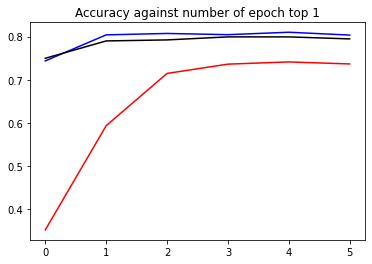

In [11]:
import matplotlib.pyplot as plt

plt.title("Accuracy against number of epoch top 1")
plt.plot([i for i in range(EPOCH_NUM)], mean_accuracies , label='test 1', color='red')
plt.plot([i for i in range(EPOCH_NUM)], topk_accuracies , label='test 1', color='blue')
plt.plot([i for i in range(EPOCH_NUM)], min_accuracies , label='test 1', color='black')


In [12]:
print("maximum of min", round(np.max(min_accuracies), 3))
print("maximum of topk", round(np.max(topk_accuracies), 3))
print("maximum of mean", round(np.max(mean_accuracies), 3))


maximum of min 0.799
maximum of topk 0.81
maximum of mean 0.741


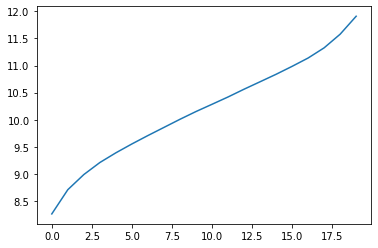

In [13]:
plt.plot(means.cpu())

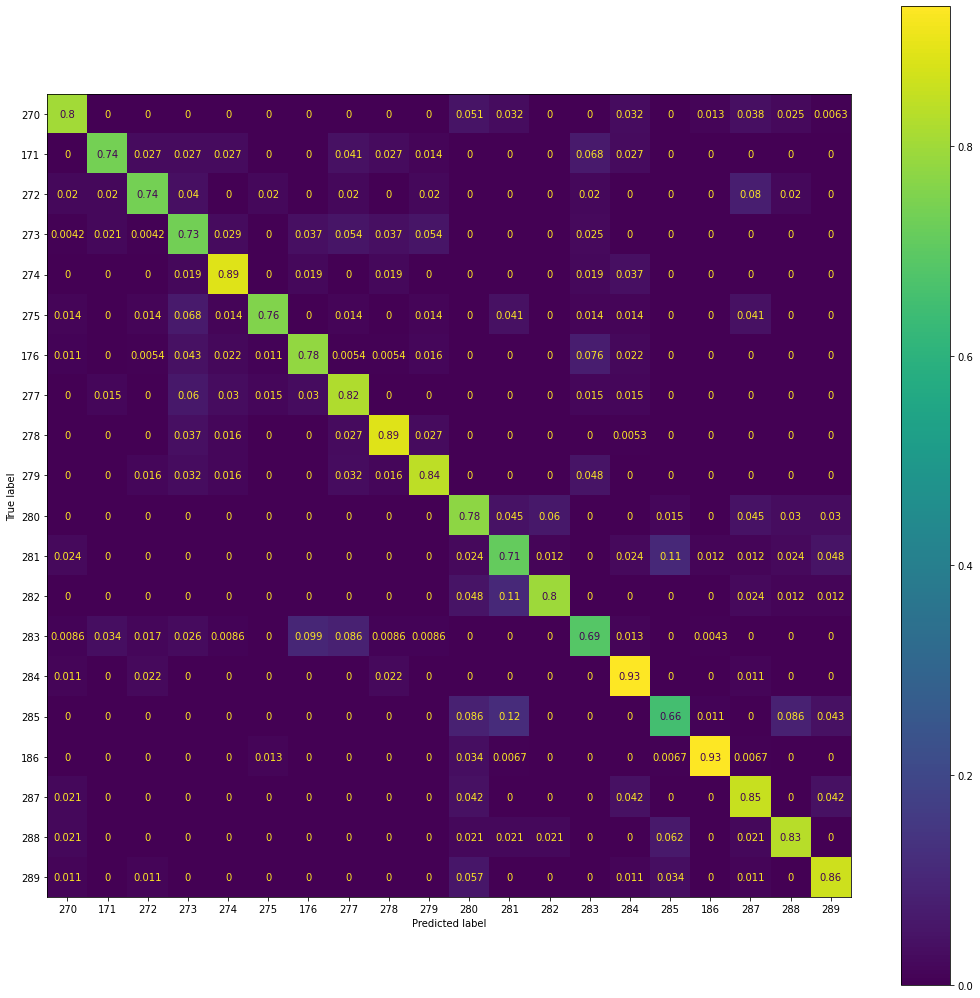

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(conf_gold_label, conf_pred_label, normalize='true')
fig, ax = plt.subplots(figsize=(18, 18))
disp = ConfusionMatrixDisplay(cm, [270, 171, 272, 273, 274, 275, 176, 277, 278, 279, 280, 281, 282, 283, 284, 285, 186, 287, 288, 289]).plot(ax=ax)
plt.show()

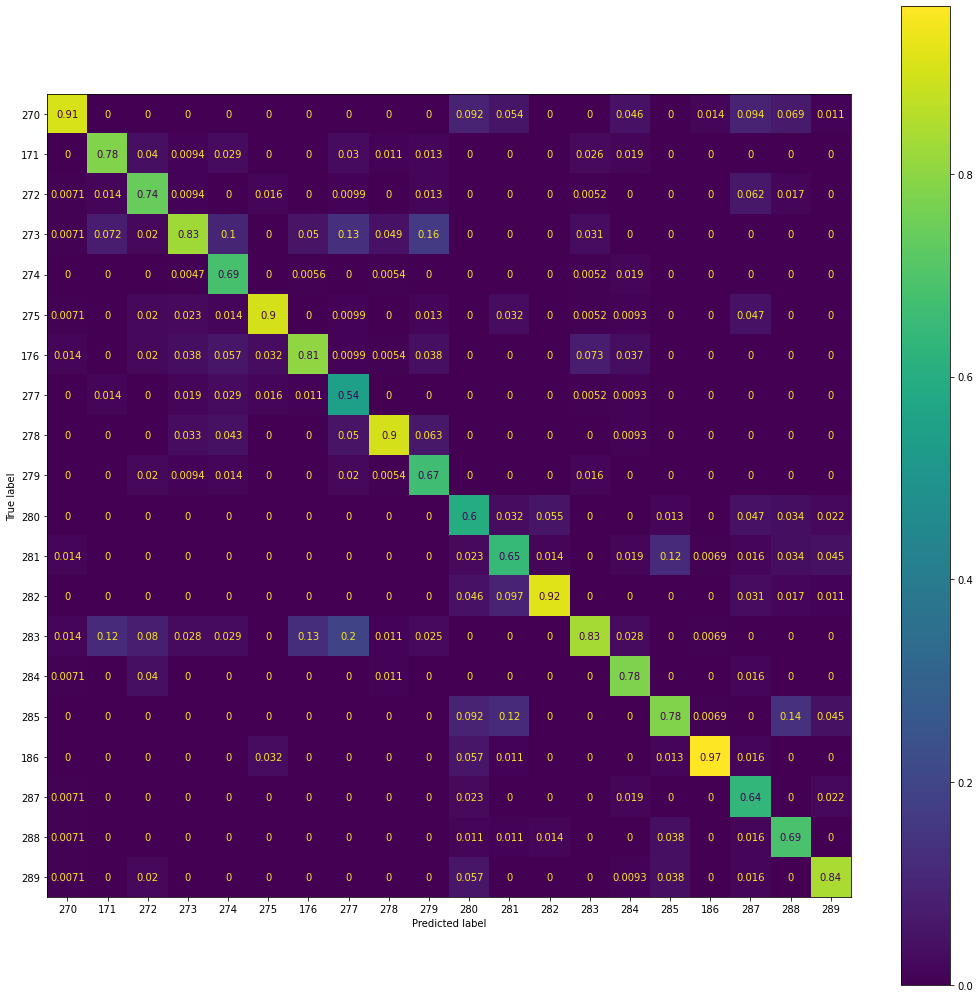

In [15]:
cm = confusion_matrix(conf_gold_label, conf_pred_label, normalize='pred')
fig, ax = plt.subplots(figsize=(18, 18))
disp = ConfusionMatrixDisplay(cm, [270, 171, 272, 273, 274, 275, 176, 277, 278, 279, 280, 281, 282, 283, 284, 285, 186, 287, 288, 289]).plot(ax=ax)
plt.show()

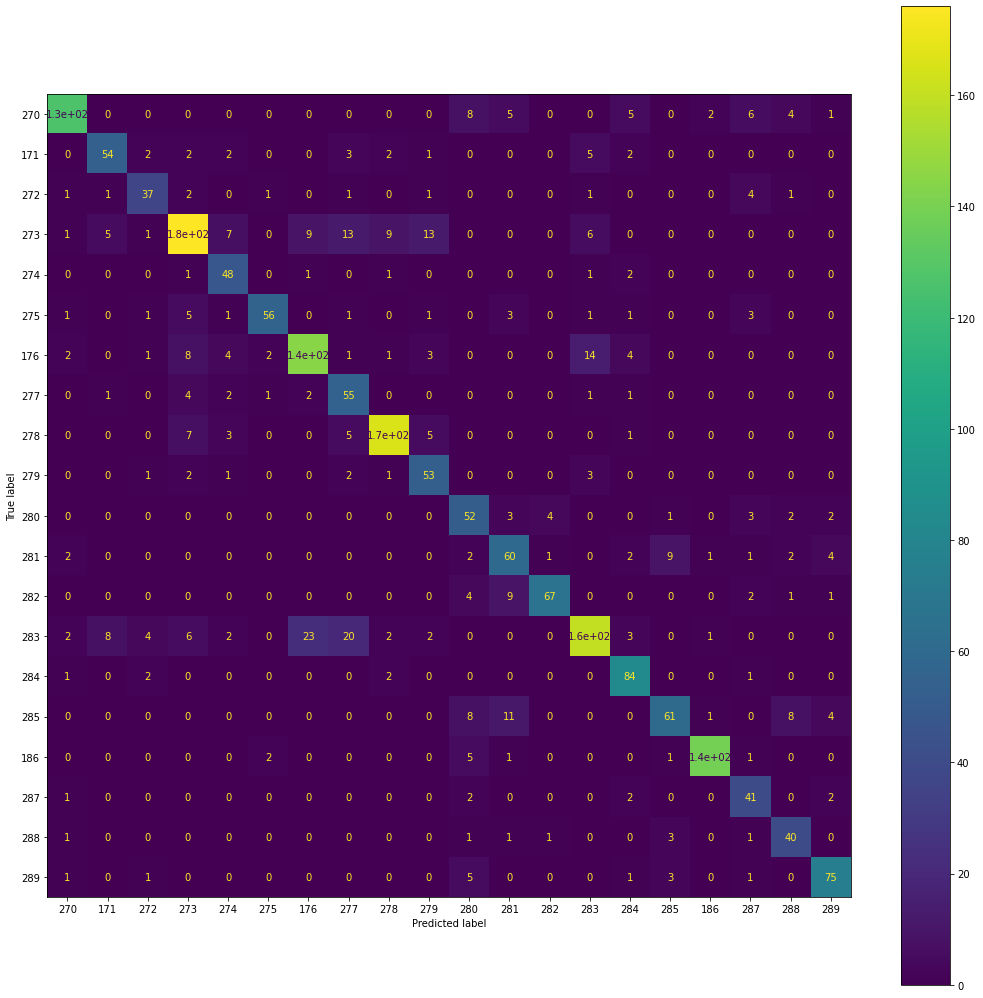

In [16]:
cm = confusion_matrix(conf_gold_label, conf_pred_label)
fig, ax = plt.subplots(figsize=(18, 18))
disp = ConfusionMatrixDisplay(cm, [270, 171, 272, 273, 274, 275, 176, 277, 278, 279, 280, 281, 282, 283, 284, 285, 186, 287, 288, 289]).plot(ax=ax)
plt.show()

In [17]:
from sklearn.metrics import f1_score

score = f1_score(conf_gold_label, conf_pred_label, average='micro')
print(score)
score = f1_score(conf_gold_label, conf_pred_label, average='weighted')
print(score)

0.7947516401124648
0.7969000900713349
